In [17]:
# basics
import numpy as np
import pandas as pd
import datetime
import re

# statistics
import statsmodels.api as sm
import statsmodels.formula.api as smf


# plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [15,12]

# own data wrappers
from imp import reload
import measureclass as mc; reload(mc);
import coronadataclass as cdc; reload(cdc);

np.seterr(divide = 'ignore');


In [18]:
# load data into datawrapper classes
measure_data = mc.COVID19_measures(download_data = True, measure_level = 2, only_first_dates = True, expand_measure_names = True)
jhu_data     = cdc.CoronaData(download_data = True)

# remove and rename countries to match the JFU database and the measures database
measure_data.RemoveCountry('Diamond Princess')
measure_data.RenameCountry('France (metropole)', 'France')
measure_data.RenameCountry('South Korea', 'Korea, South')
measure_data.RenameCountry('Czech Republic', 'Czechia')


In [6]:
# helper functions

def date2vector(implementdate, start = '22/1/20', end = None, shiftdays = 0):
    # generate vector of 0s and 1s when measure is implemented or not
    starttime     = datetime.datetime.strptime(start,         '%d/%m/%y')
    if end is None:
        endtime   = datetime.datetime.today()
    else:
        endtime   = datetime.datetime.strptime(end,           '%d/%m/%y')
    implementtime = datetime.datetime.strptime(implementdate, '%d/%m/%Y')
    
    totaldays   = (endtime       - starttime).days
    measuredays = (implementtime - starttime).days
    
    vec         = np.zeros(totaldays)
    vec[min(measuredays+shiftdays,len(vec)-1):] = 1
    
    return vec


def ConvertDateFormat(date):
    m,d,y = date.split('/')
    return '{:02d}/{:02d}/{:02d}'.format(int(d),int(m),int(y))


def CleanUpMeasureName(measurename):
    # regression model formula can't contain special characters
    return ''.join([mn.capitalize() for mn in measurename.replace(',','').replace('-','').replace('/','').split(' ')])

In [13]:
def GetMeasureIDs(countrylist = None, measure_level = 2, mincount = None, extend_measure_names = False):
    if countrylist is None:
        countrylist = measure_data.countrylist # use ALL countries
    
    measurelist = {}
    
    # get all restrictions from countries
    for country in countrylist:
        country_measures = measure_data.CountryData(country, measure_level = 2, extend_measure_names = extend_measure_names)
        for measurename, initialdata in country_measures.items():
            if not measurename in measurelist.keys():
                measurelist[measurename] = 0
            measurelist[measurename] += 1
    
    if not mincount is None:
        # rebuild dict with restrictions
        measurelist = {k:v for k,v in measurelist.items() if v >= mincount}

    return measurelist


def SmoothTrajectories3(traj):
    if len(traj) > 3:
        newtraj       = np.zeros(len(traj))
        newtraj[0]    = (             2 * traj[0]    + traj[1] )/3.
        newtraj[1:-1] = (traj[0:-2] + 2 * traj[1:-1] + traj[2:])/4.
        newtraj[-1]   = (traj[-2]   + 2 * traj[-1]             )/3.
        return newtraj
    else:
        return traj


def GetCountryTrajectories(countrylist = None, data = 'Confirmed', startcases = None, maxlen = None, smooth = False):
    if countrylist is None:
        countrylist = jhu_data.countrylist
    
    trajectories = {}
    for country in [c for c in countrylist if c in jhu_data.countrylist]:
        ctraj = np.array(jhu_data.CountryData(country)[data], dtype = np.float)
        starttraj = 0
        if not startcases is None:
            starttraj = np.argmax(ctraj >= startcases)
            ctraj = ctraj[starttraj:]
            if not maxlen is None:
                ctraj = ctraj[:min(maxlen,len(ctraj))]
        trajectories[country] = {}
        if smooth:
            ctraj = SmoothTrajectories3(ctraj)
        trajectories[country]['traj'] = ctraj
        trajectories[country]['startdate'] = ConvertDateFormat(jhu_data.CountryData(country)['Date'][starttraj])
    
    return trajectories

        
def GetRegressionDF(countrylist = None, measure_level = 2, shiftdays = 0, verbose = False, maxlen = None, smooth = None):
    # construct pd.DataFrame used for regression
    
    # get trajectories and measure list for all countries in 'countrylist'
    trajectories         = GetCountryTrajectories(countrylist = countrylist, data = 'Confirmed', startcases = 30, maxlen = maxlen, smooth = smooth)
    measureIDs           = measure_data.MeasureList(countrylist = countrylist, measure_level = 2, mincount = 5)
    cleaned_measurelist  = {CleanUpMeasureName(mn):count for mn,count in measureIDs.items()}
    regressionDF         = None
    
    if verbose:
        print(measureIDs)
    
    for country in trajectories.keys():
        if country in measure_data.countrylist:

            # ********************************************
            # change observable to regress here:
            observable                  = np.diff(np.log(trajectories[country]['traj']))
            obslen                      = len(observable)
            # ********************************************
            
            DF_country = measure_data.ImplementationTable(country           = country,
                                                        measure_level     = 2,
                                                        startdate         = trajectories[country]['startdate'],
                                                        shiftdays         = shiftdays,
                                                        maxlen            = obslen,
                                                        clean_measurename = True)
            
            for measurename in DF_country.columns:
                if measurename not in measureIDs.keys():
                    DF_country.drop(labels = measurename, axis = 'columns')
            
            DF_country['Country']    = country
            DF_country['Observable'] = observable

            
            if not (np.isnan(DF_country['Observable']).any() or np.isinf(DF_country['Observable']).any()):

                if regressionDF is None:
                    regressionDF = DF_country
                else:
                    regressionDF = pd.concat([regressionDF,DF_country], ignore_index = True, sort = False)
    
    # not implemented measures should be NaN values, set them to 0
    regressionDF.fillna(0, inplace = True)
    
    return regressionDF, cleaned_measurelist



def GetCountryMasks(regrDF):
    countrylist = list(regrDF['Country'].unique())
    maskdict = {}
    for country in countrylist:
        mask = list(regrDF['Country'] == country)
        maskdict[country] = mask
    return maskdict


def CrossValidationFit(trainmodel, testmodel, header = None, alpha = 1e-5):
    results = trainmodel.fit_regularized(alpha = alpha, L1_wt = 1)
    
    result_dict = {}
    if header is not None:
        result_dict.update(header)

    test_params = []
    for paramname in testmodel.exog_names:
        if paramname in results.params.keys():
            test_params.append(results.params[paramname])
        else:
            test_params.append(0)

    result_dict['Loglike Training'] = trainmodel.loglike(results.params)
    result_dict['Loglike Test']     = testmodel.loglike(np.array(test_params))

    obs_train  = np.array(trainmodel.endog)
    obs_test   = np.array(testmodel.endog)

    pred_train = trainmodel.predict(results.params)
    pred_test  = testmodel.predict(test_params)

    result_dict['R2 Training']      = 1 - np.sum((obs_train - pred_train)**2)/np.sum((obs_train - np.mean(obs_train))**2)
    result_dict['R2 Test']          = 1 - np.sum((obs_test - pred_test)**2)/np.sum((obs_test - np.mean(obs_test))**2)

    result_dict['RSS Training']     = np.sum((obs_train - pred_train)**2)
    result_dict['RSS Test']         = np.sum((obs_test - pred_test)**2)

    result_dict.update({k:v for k,v in results.params.items()})

    return result_dict

In [11]:
# set up of all models
# for cross-validation by excluding each country

maxshift           = 10
regrDF             = []
model_excludeC     = []
model_singleC      = []
allresults_country = None

for shiftdays in range(0, maxshift + 1):
    print('shiftdays = {}'.format(shiftdays))
    tmp, measurelist = GetRegressionDF(countrylist = measure_data.countrylist, shiftdays = shiftdays, smooth = True)
    regrDF.append(tmp)

    countrylist = tmp['Country'].unique()
    formula     = 'Observable ~ C(Country) + ' + ' + '.join(measurelist)
    
    model_excludeC.append(dict())
    model_singleC.append(dict())
    
    for country in countrylist:
        DF_excludeC = regrDF[shiftdays][regrDF[shiftdays]['Country'] != country]
        DF_singleC  = regrDF[shiftdays][regrDF[shiftdays]['Country'] == country]
        model_excludeC[shiftdays][country] = smf.ols(formula = formula, data = DF_excludeC)
        model_singleC [shiftdays][country] = smf.ols(formula = formula, data = DF_singleC)
    


shiftdays = 0
shiftdays = 1
shiftdays = 2
shiftdays = 3
shiftdays = 4
shiftdays = 5
shiftdays = 6
shiftdays = 7
shiftdays = 8
shiftdays = 9
shiftdays = 10


In [14]:
allresults_country = None

In [15]:
#llres = None
for shiftdays in np.arange(maxshift + 1):
    
    print('shiftdays = {}'.format(shiftdays))
    
    for alpha in np.power(10,np.linspace(-5, -3, num = 11)):
        print('   alpha = {:.6f}'.format(alpha))
        for country in countrylist:
            result_dict = CrossValidationFit( trainmodel = model_excludeC[shiftdays][country],
                                              testmodel  = model_singleC[shiftdays][country],
                                              header     = {'shiftdays':shiftdays, 'alpha':alpha, 'excludeC':country},
                                              alpha      = alpha)
            
            if allresults_country is None:
                allresults_country = pd.DataFrame({k:np.array([v]) for k,v in result_dict.items()})
            else:
                allresults_country = allresults_country.append(result_dict, ignore_index = True)
        

shiftdays = 0
   alpha = 0.000010
   alpha = 0.000016
   alpha = 0.000025
   alpha = 0.000040
   alpha = 0.000063
   alpha = 0.000100
   alpha = 0.000158
   alpha = 0.000251
   alpha = 0.000398
   alpha = 0.000631
   alpha = 0.001000
shiftdays = 1
   alpha = 0.000010
   alpha = 0.000016
   alpha = 0.000025
   alpha = 0.000040
   alpha = 0.000063
   alpha = 0.000100
   alpha = 0.000158
   alpha = 0.000251
   alpha = 0.000398
   alpha = 0.000631
   alpha = 0.001000
shiftdays = 2
   alpha = 0.000010
   alpha = 0.000016
   alpha = 0.000025
   alpha = 0.000040
   alpha = 0.000063
   alpha = 0.000100
   alpha = 0.000158
   alpha = 0.000251
   alpha = 0.000398
   alpha = 0.000631
   alpha = 0.001000
shiftdays = 3
   alpha = 0.000010
   alpha = 0.000016
   alpha = 0.000025
   alpha = 0.000040
   alpha = 0.000063
   alpha = 0.000100
   alpha = 0.000158
   alpha = 0.000251
   alpha = 0.000398
   alpha = 0.000631
   alpha = 0.001000
shiftdays = 4
   alpha = 0.000010
   alpha = 0.000016
   alpha =

In [16]:
allresults_country.to_csv('results_country_200411.csv')

In [ ]:
# for shiftdays in np.arange(maxshift + 1):
    
    print('shiftdays = {}'.format(shiftdays))
    
    for alpha in np.power(10,np.linspace(-5, -4, num = 10, endpoint = False)):
        print('   alpha = {:.6f}'.format(alpha))
        for country in countrylist:
            results = model_excludeC[shiftdays][country].fit_regularized(alpha = alpha, L1_wt = 1)
            
            result_dict = {}
            result_dict['shiftdays']        = shiftdays
            result_dict['alpha']            = alpha
            result_dict['excludeC']         = country
            
            param_excludeC                  = np.array(results.params)
            param_singleC                   = np.concatenate([np.array([param_excludeC[0]]),param_excludeC[len(countrylist)-1:]])

            result_dict['Loglike Training'] = model_excludeC[shiftdays][country].loglike(results.params)
            result_dict['Loglike Test']     = model_singleC[shiftdays][country].loglike(param_singleC)

            result_dict.update({k:v for k,v in results.params.items()})
            
            if allresults is None:
                allresults = pd.DataFrame({k:np.array([v]) for k,v in result_dict.items()})
            else:
                allresults = allresults.append(result_dict, ignore_index = True)


In [ ]:
allresults.to_csv('results_Xval_country.csv')

In [ ]:
allresults = pd.read_csv('results_Xval_country.csv')

In [ ]:
colornames = [cn for cn in matplotlib.colors.TABLEAU_COLORS.keys() if (cn.upper() != 'TAB:WHITE' and cn.upper() != 'TAB:GRAY')]

shiftdaylist = allresults['shiftdays'].unique()
alphalist    = allresults['alpha'].unique()

fig,ax = plt.subplots(2,1)

for shiftdays in shiftdaylist:
    lltest_list = []
    lltrain_list = []
    for alpha in alphalist:
        lltest_list.append(np.mean(allresults[(allresults['shiftdays']==shiftdays) & (allresults['alpha'] == alpha)]['Loglike Test']))
        lltrain_list.append(np.mean(allresults[(allresults['shiftdays']==shiftdays) & (allresults['alpha'] == alpha)]['Loglike Training']))
    ax[0].plot(alphalist,lltest_list, label = 'shiftdays = {}'.format(shiftdays), marker = 'o')
    ax[1].plot(alphalist,lltrain_list, label = 'shiftdays = {}'.format(shiftdays), marker = 'o')
    pd.DataFrame({'alpha':alphalist,'loglike train':lltrain_list,'loglike test':lltest_list}).to_csv('average_LogLikelihood_Xval_country_sd{}.csv'.format(shiftdays))
ax[0].legend()
ax[0].set_xscale('log')
ax[0].set_xlim([1e-6/2,2e0])
ax[0].set_xlabel(r'alpha')
ax[0].set_ylabel('Average Test Log Likelihood')
ax[1].set_xscale('log')
ax[1].set_xlim([1e-6/2,2e0])
ax[1].set_xlabel(r'alpha')
ax[1].set_ylabel('Average Training Log Likelihood')
plt.savefig('loglikelihood_Xval_country.pdf')




In [25]:
# cross-validation with random sampling

maxshift     = 10
regrDF       = {}
model_train  = {}
model_test   = {}

regrDF_train = {}
regrDF_test  = {}

allresults_rndXv_chunksize2 = None



for shiftdays in range(5, 10):
    print('generating DF and model for shiftdays = {}'.format(shiftdays))
    regrDF[shiftdays], measurelist = GetRegressionDF( countrylist = measure_data.countrylist,
                                                      shiftdays   = shiftdays,
                                                      smooth      = True)

    countrylist = tmp['Country'].unique()
    formula     = 'Observable ~ C(Country) + ' + ' + '.join(measurelist)
    
    # generate random list of samples for 10x cross validation
    xval_count = 10
    datalen    = len(regrDF[shiftdays])
    chunklen   = np.ones(xval_count,dtype = np.int) * (datalen // xval_count)
    chunklen[:datalen%xval_count] += 1
    samples    = np.random.permutation(np.concatenate([i*np.ones(chunklen[i],dtype = np.int) for i in range(xval_count)]))

    assert len(samples) == datalen
    
    regrDF_train[shiftdays] = []
    regrDF_test [shiftdays] = []
    model_train [shiftdays] = []
    model_test  [shiftdays] = []
    
    for i in range(xval_count):
        regrDF_train[shiftdays].append(regrDF[shiftdays][samples != i])
        regrDF_test [shiftdays].append(regrDF[shiftdays][samples == i])
        
        model_train [shiftdays].append(smf.ols(formula = formula, data = regrDF_train[shiftdays][i]))
        model_test  [shiftdays].append(smf.ols(formula = formula, data = regrDF_test[shiftdays][i]))


generating DF and model for shiftdays = 5
generating DF and model for shiftdays = 6
generating DF and model for shiftdays = 7
generating DF and model for shiftdays = 8
generating DF and model for shiftdays = 9


In [26]:
for shiftdays in np.arange(5,10):
    
    print('shiftdays = {}'.format(shiftdays))
    
    for alpha in np.power(10,np.linspace(-6, -3.4, num = 14, endpoint = True)):
        print('   alpha = {:.6f}'.format(alpha))
        for i in range(xval_count):
            
            result_dict = CrossValidationFit( trainmodel = model_train[shiftdays][i],
                                              testmodel  = model_test[shiftdays][i],
                                              header     = {'shiftdays':shiftdays, 'alpha':alpha, 'iteration':i},
                                              alpha      = alpha)

            
            if allresults_rndXv_chunksize2 is None:
                allresults_rndXv_chunksize2 = pd.DataFrame({k:np.array([v]) for k,v in result_dict.items()})
            else:
                allresults_rndXv_chunksize2 = allresults_rndXv_chunksize2.append(result_dict, ignore_index = True)

allresults_rndXv_chunksize2.to_csv('results_Xval_rnd10_200411_4.csv')

shiftdays = 5
   alpha = 0.000001
   alpha = 0.000002
   alpha = 0.000003
   alpha = 0.000004
   alpha = 0.000006
   alpha = 0.000010
   alpha = 0.000016
   alpha = 0.000025
   alpha = 0.000040
   alpha = 0.000063
   alpha = 0.000100
   alpha = 0.000158
   alpha = 0.000251
   alpha = 0.000398
shiftdays = 6
   alpha = 0.000001
   alpha = 0.000002
   alpha = 0.000003
   alpha = 0.000004
   alpha = 0.000006
   alpha = 0.000010
   alpha = 0.000016
   alpha = 0.000025
   alpha = 0.000040
   alpha = 0.000063
   alpha = 0.000100
   alpha = 0.000158
   alpha = 0.000251
   alpha = 0.000398
shiftdays = 7
   alpha = 0.000001
   alpha = 0.000002
   alpha = 0.000003
   alpha = 0.000004
   alpha = 0.000006
   alpha = 0.000010
   alpha = 0.000016
   alpha = 0.000025
   alpha = 0.000040
   alpha = 0.000063
   alpha = 0.000100
   alpha = 0.000158
   alpha = 0.000251
   alpha = 0.000398
shiftdays = 8
   alpha = 0.000001
   alpha = 0.000002
   alpha = 0.000003
   alpha = 0.000004
   alpha = 0.000006
   a

In [ ]:
allresults_rndXv.to_csv('results_Xval_rnd10_200411.csv')

In [18]:
allresults_rndXv.head()

,shiftdays,alpha,iteration,Loglike Training,Loglike Test,R2 Training,R2 Test,Intercept,C(Country)[T.Austria],C(Country)[T.Belgium],...,PublicTransport,RepurposeHospitals,TrainTransportRestrictions,EnvironmentalCleaningAndDisinfection,Surveillance,WorkSafetyProtocols,SpecialMeasuresForCertainEstablishments,IncreaseHealthcareWorkforce,FixingPriceForSpecificProtectiveProducts,AirportsClosingForAllInternationalFlights
0,0.0,0.000001,0.0,1607.518058,195.470798,0.564053,0.530093,0.244475,0.080744,-0.010957,...,-0.019075,0.001854,-0.104650,0.009232,0.003626,0.031063,0.079465,-0.010721,0.080099,0.104635
1,0.0,0.000001,1.0,1683.767047,126.872325,0.588775,0.228858,0.250285,0.084444,0.000000,...,-0.026106,-0.000030,-0.123455,-0.004185,-0.001124,0.020948,0.070243,-0.032988,0.085481,0.111075
2,0.0,0.000001,2.0,1657.069180,146.421897,0.570339,0.443524,0.237679,0.059890,0.038956,...,-0.014333,-0.005451,-0.127441,0.011171,0.009715,0.027428,0.069368,-0.024734,0.070645,0.107942
3,0.0,0.000001,3.0,1622.767627,180.422348,0.570088,0.472000,0.250966,0.033030,0.008450,...,-0.032719,-0.015641,-0.134009,0.017517,0.003570,0.025605,0.070142,-0.001945,0.069495,0.117172
4,0.0,0.000001,4.0,1644.881086,159.936315,0.564341,0.507280,0.251143,0.046745,0.000000,...,-0.023803,-0.005944,-0.152998,0.006546,-0.001115,0.021970,0.073919,-0.018825,0.095618,0.116991


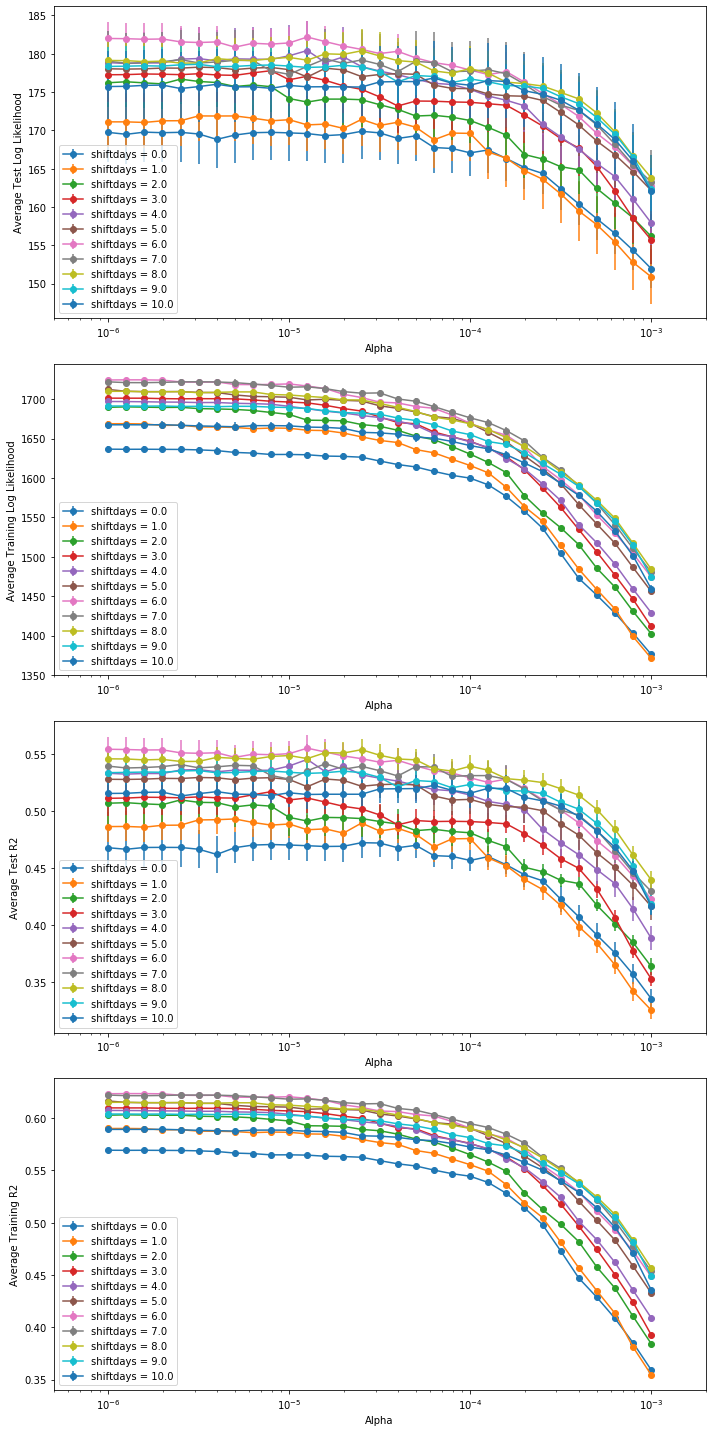

In [38]:
shiftdaylist = allresults_rndXv['shiftdays'].unique()
alphalist    = allresults_rndXv['alpha'].unique()

fig,ax = plt.subplots(4,1,figsize = (10,20))
avg_loglike_rnd10 = None
for shiftdays in shiftdaylist:
    lltest_mean = []
    lltrain_mean = []
    lltest_std = []
    lltrain_std = []
    r2test_mean = []
    r2test_std  = []
    r2train_mean = []
    r2train_std = []
    for alpha in alphalist:
        boolidx = (allresults_rndXv['shiftdays']==shiftdays) & (allresults_rndXv['alpha'] == alpha)
        lltest_mean.append (np.mean((allresults_rndXv[boolidx])['Loglike Test']))
        lltest_std.append  (np.std ((allresults_rndXv[boolidx])['Loglike Test']))
        lltrain_mean.append(np.mean((allresults_rndXv[boolidx])['Loglike Training']))
        lltrain_std.append (np.std ((allresults_rndXv[boolidx])['Loglike Training']))

        r2test_mean.append (np.mean((allresults_rndXv[boolidx])['R2 Test']))
        r2test_std.append  (np.std ((allresults_rndXv[boolidx])['R2 Test']))
        r2train_mean.append(np.mean((allresults_rndXv[boolidx])['R2 Training']))
        r2train_std.append (np.std ((allresults_rndXv[boolidx])['R2 Training']))
    
    resdict = {'shiftdays':         shiftdays * np.ones(len(alphalist),dtype=int),
               'alpha':             np.array(alphalist),
               'loglike train':     np.array(lltrain_mean),
               'loglike train std': np.array(lltrain_std)/np.sqrt(len(lltrain_std)),
               'loglike test':      np.array(lltest_mean),
               'loglike test std':  np.array(lltest_std)/np.sqrt(len(lltest_std)),
               'R2 train':          np.array(r2train_mean),
               'R2 train std':      np.array(r2train_std)/np.sqrt(len(r2train_std)),
               'R2 test':           np.array(r2test_mean),
               'R2 test std':       np.array(r2test_std)/np.sqrt(len(r2test_std)),
              
              }
    
    if avg_loglike_rnd10 is None:
        avg_loglike_rnd10 = pd.DataFrame(resdict)
    else:
        avg_loglike_rnd10 = avg_loglike_rnd10.append(pd.DataFrame(resdict), ignore_index = True)

#maxval = np.max(avg_loglike_rnd10['loglike test'])        
#print(avg_loglike_rnd10)
avg_loglike_rnd10.sort_values(by = 'alpha', inplace = True)

for shiftdays in shiftdaylist:
    ax[0].errorbar(alphalist, avg_loglike_rnd10[avg_loglike_rnd10['shiftdays']==shiftdays]['loglike test'],  yerr = avg_loglike_rnd10[avg_loglike_rnd10['shiftdays']==shiftdays]['loglike test std'],  label = 'shiftdays = {}'.format(shiftdays), marker = 'o')
    ax[1].errorbar(alphalist, avg_loglike_rnd10[avg_loglike_rnd10['shiftdays']==shiftdays]['loglike train'], yerr = avg_loglike_rnd10[avg_loglike_rnd10['shiftdays']==shiftdays]['loglike train std'], label = 'shiftdays = {}'.format(shiftdays), marker = 'o')
    ax[2].errorbar(alphalist, avg_loglike_rnd10[avg_loglike_rnd10['shiftdays']==shiftdays]['R2 test'],       yerr = avg_loglike_rnd10[avg_loglike_rnd10['shiftdays']==shiftdays]['R2 test std'],       label = 'shiftdays = {}'.format(shiftdays), marker = 'o')
    ax[3].errorbar(alphalist, avg_loglike_rnd10[avg_loglike_rnd10['shiftdays']==shiftdays]['R2 train'],      yerr = avg_loglike_rnd10[avg_loglike_rnd10['shiftdays']==shiftdays]['R2 train std'],      label = 'shiftdays = {}'.format(shiftdays), marker = 'o')

for i in range(4):
    ax[i].set_xlim([1e-6/2,2e-3])
    ax[i].set_xscale('log')
    ax[i].set_xlabel(r'Alpha')
    ax[i].legend()
#ax[0].set_ylim([-10,1])
ax[0].set_ylabel('Average Test Log Likelihood')
ax[1].set_ylabel('Average Training Log Likelihood')
ax[2].set_ylabel('Average Test R2')
ax[3].set_ylabel('Average Training R2')
fig.tight_layout()
plt.savefig('loglikelihood_Xval_rnd10.pdf')

avg_loglike_rnd10.to_csv('avg_loglike_rnd10.csv')

In [40]:
# use parameters from country-wise cross validation
# shiftdays = 6, alpha = 2e-5
model_final6   = smf.ols(formula = formula, data = regrDF[6])
results_final6 = model_final6.fit_regularized(alpha = 2e-5, L1_wt = 1)

model_final7   = smf.ols(formula = formula, data = regrDF[7])
results_final7 = model_final7.fit_regularized(alpha = 2e-5, L1_wt = 1)

model_final8   = smf.ols(formula = formula, data = regrDF[8])
results_final8 = model_final8.fit_regularized(alpha = 2e-5, L1_wt = 1)



In [41]:
colornames = ['gray','#f563e2','#609cff','#00bec4','#00b938','#b79f00','#f8766c']
#colornames = [cn for cn in matplotlib.colors.TABLEAU_COLORS.keys() if (cn.upper() != 'TAB:WHITE' and cn.upper() != 'TAB:GRAY')]

countrylist = [paramname.split('.')[1].split(']')[0] for paramname in results_final7.params.index if paramname[:3] == 'C(C']

# collect measure names for labels
ml = GetMeasureIDs(measure_level = 2,mincount = 5, extend_measure_names=True)
measure_level_dict = {}
for mn in ml.keys():
    l1,l2 = mn.split(' - ')
    if not l1 in measure_level_dict.keys():
        measure_level_dict[l1] = {}
    measure_level_dict[l1][l2] = CleanUpMeasureName(l2)

intercept6 = results_final6.params['Intercept']
intercept7 = results_final7.params['Intercept']
intercept8 = results_final8.params['Intercept']


/home/lukas/projects/corona/programs/measureclass.py:107: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  countrydata['Measure_L{:d}'.format(ml)] = countrydata['Measure_L{:d}'.format(ml)].fillna(countrydata['Measure_L{:d}'.format(ml-1)])
/home/lukas/projects/corona/programs/measureclass.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  countrydata['MN'] = countrydata[['Measure_L{:d}'.format(ml+1) for ml in range(measure_level)]].agg(' - '.join, axis = 1)


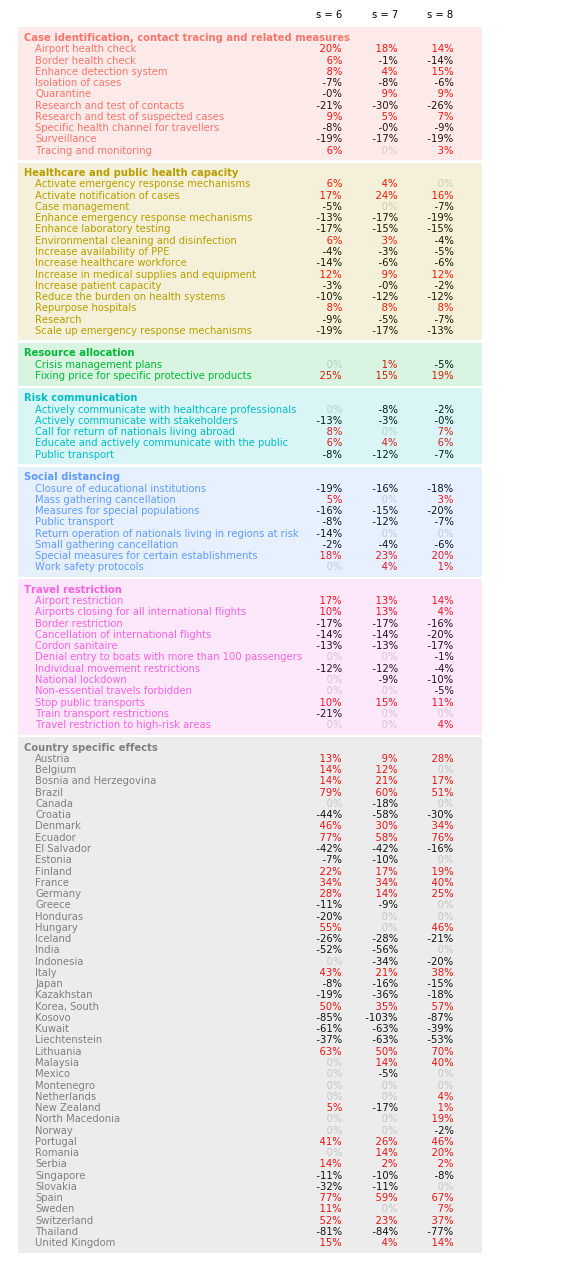

In [43]:
def significanceColor(beta):
    if beta   >  0.00: return 'red'
    elif beta == 0.00: return 'lightgray'
    else:              return 'black'

    
l1list = list(measure_level_dict.keys())
l1list.sort()

fig,ax = plt.subplots(figsize = (10,23))

i = 0
groupcolor = 0

label_x = 1
label_x_header = .6
value_x  = 12
value_dx = 2
boxalpha = .15
ax.annotate('Country specific effects',[label_x_header, len(countrylist)], c = colornames[groupcolor], weight = 'bold' )

background = plt.Rectangle([label_x - .6, i - .65], value_x + 4.6, len(countrylist) + 1.8, fill = True, fc = colornames[groupcolor], alpha = boxalpha, zorder = 10)
ax.add_patch(background)


for country in countrylist[::-1]:
    ax.annotate(country, [label_x, i], c= colornames[groupcolor])
    beta_val6 = results_final6.params['C(Country)[T.{}]'.format(country)] / intercept6
    beta_val7 = results_final7.params['C(Country)[T.{}]'.format(country)] / intercept7
    beta_val8 = results_final8.params['C(Country)[T.{}]'.format(country)] / intercept8
    c6 = significanceColor(beta_val6)
    c7 = significanceColor(beta_val7)
    c8 = significanceColor(beta_val8)
    ax.annotate('{:6.0f}%'.format(beta_val6*100),[value_x + 0 * value_dx, i], c = c6, ha = 'right')
    ax.annotate('{:6.0f}%'.format(beta_val7*100),[value_x + 1 * value_dx, i], c = c7, ha = 'right')
    ax.annotate('{:6.0f}%'.format(beta_val8*100),[value_x + 2 * value_dx, i], c = c8, ha = 'right')
    i += 1

groupcolor += 1

i+=2 

for l1 in l1list[::-1]:
    ax.annotate(l1,[label_x_header, i + len(measure_level_dict[l1])], c = colornames[groupcolor], weight = 'bold')
    l2list = list(measure_level_dict[l1].keys())
    l2list.sort()
    
    background = plt.Rectangle([label_x - .6, i - .65], value_x + 4.6, len(measure_level_dict[l1]) + 1.8, fill = True, fc = colornames[groupcolor], alpha = boxalpha, zorder = 10)
    ax.add_patch(background)
    
    for l2 in l2list[::-1]:
        ax.annotate(l2,[label_x,i],c = colornames[groupcolor])
        beta_val6 = results_final6.params[measure_level_dict[l1][l2]]/intercept6
        beta_val7 = results_final7.params[measure_level_dict[l1][l2]]/intercept7
        beta_val8 = results_final8.params[measure_level_dict[l1][l2]]/intercept8
        c6 = significanceColor(beta_val6)
        c7 = significanceColor(beta_val7)
        c8 = significanceColor(beta_val8)
        ax.annotate('{:6.0f}%'.format(beta_val6*100),[value_x + 0 * value_dx,i],c=c6,ha='right')
        ax.annotate('{:6.0f}%'.format(beta_val7*100),[value_x + 1 * value_dx,i],c=c7,ha='right')
        ax.annotate('{:6.0f}%'.format(beta_val8*100),[value_x + 2 * value_dx,i],c=c8,ha='right')
        i+=1
    i+=2
    groupcolor += 1
        #print('  {:60s} {:6.3f}'.format(l2,results_final.params[measure_level_dict[l1][l2]]/intercept))

ax.annotate('s = 6', [value_x + 0*value_dx,i],ha='right')        
ax.annotate('s = 7', [value_x + 1*value_dx,i],ha='right')        
ax.annotate('s = 8', [value_x + 2*value_dx,i],ha='right')

ax.set_xlim([0,20])
ax.set_ylim([-1,i+1])
ax.axis('off')
plt.savefig('effects_measures.pdf')


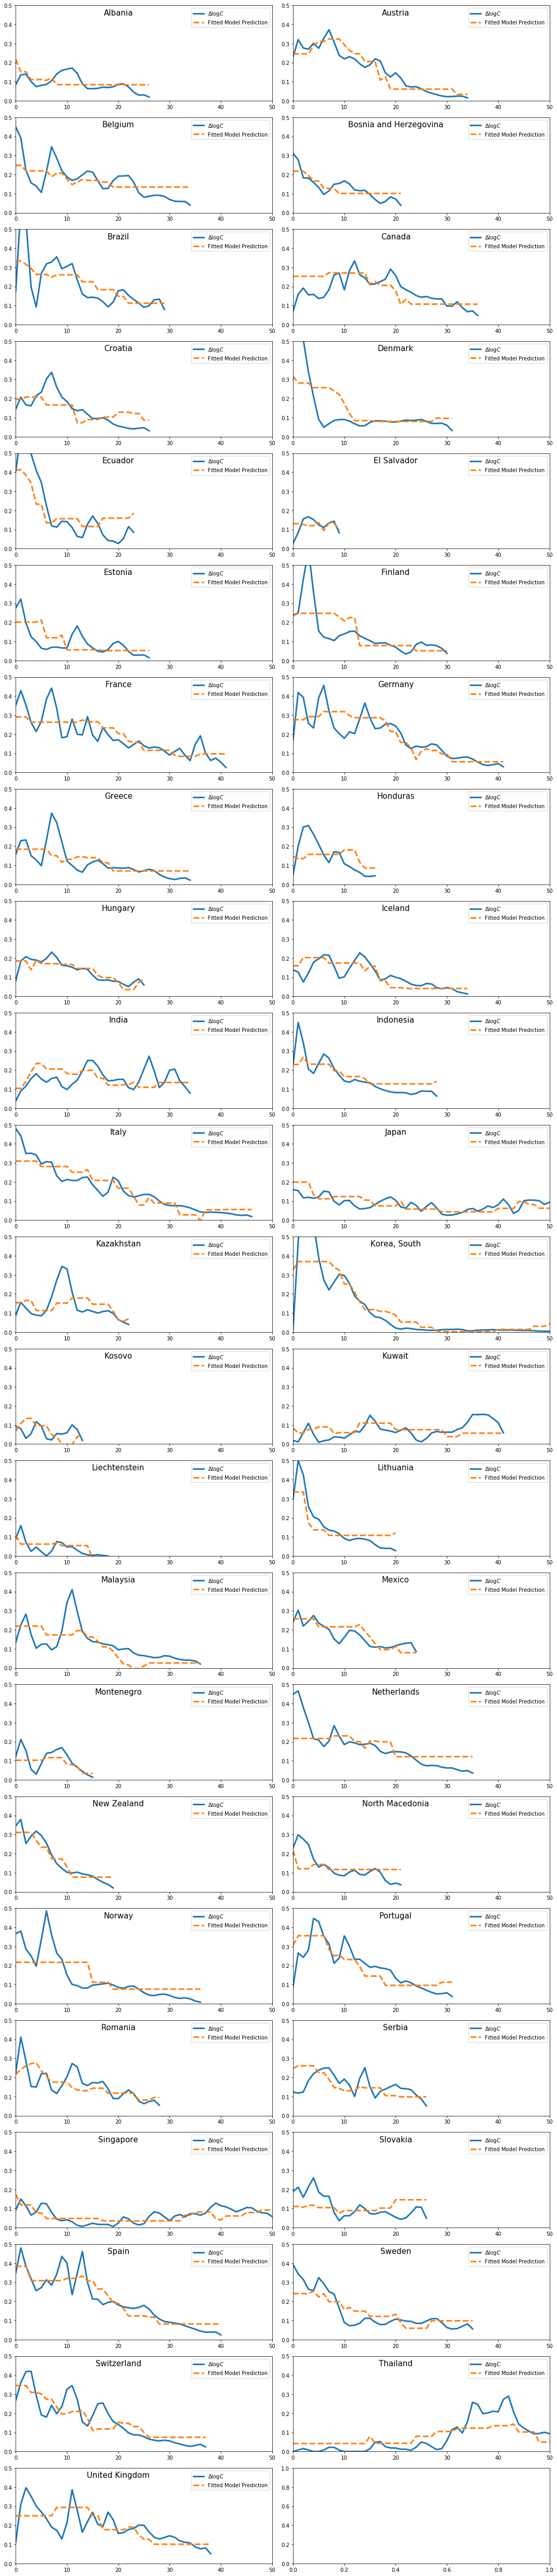

In [44]:
#specialcountries = ['Austria','Germany','Thailand', 'Italy', 'Spain', 'Sweden',
#                    'Japan', 'Hungary', 'France', 'Mexico', 'Netherlands', 'Korea, South']
specialcountries = regrDF[6]['Country'].unique()
cm = GetCountryMasks(regrDF[6])

plotxcount = int(len(specialcountries)/2) + len(specialcountries)%2

fig,ax = plt.subplots(plotxcount,2,figsize = (15,3*plotxcount))
ax = ax.flatten()

for i,country in enumerate(specialcountries):
    dlc = np.array(regrDF[6][cm[country]]['Observable'])
    pred = results_final6.predict()[cm[country]]
    ax[i].plot(dlc, lw = 3, c = 'TAB:BLUE', label = r'$\Delta \log C$')
    ax[i].plot(pred, lw = 3, c = 'TAB:ORANGE', linestyle = '--', label = 'Fitted Model Prediction')
    ax[i].set_ylim([0,.5])
    ax[i].set_xlim([0,50])
    ax[i].annotate(country, [20,.45],ha = 'center',fontsize = 15)
    ax[i].legend()
fig.tight_layout()
plt.savefig('regression_trajectories.pdf')


In [ ]:
import pickle

pickle.dump(regrDF, open('pickle/regrDF.pickle','wb'))
pickle.dump(regrDF_test, open('pickle/regrDF_test.pickle','wb'))
pickle.dump(regrDF_train, open('pickle/regrDF_train.pickle','wb'))
pickle.dump(model_excludeC, open('pickle/model_excludeC.pickle','wb'))
pickle.dump(model_singleC, open('pickle/model_singleC.pickle','wb'))


In [ ]:
allresults_rndXv_RR = None

In [ ]:
# ridge regression

for shiftdays in np.arange(maxshift + 1):
    
    print('shiftdays = {}'.format(shiftdays))
    
    for alpha in np.power(10,np.linspace(-6, -2, num = 5, endpoint = True)):
        print('   alpha = {:.6f}'.format(alpha))
        for i in range(xval_count):
            results = model_train[shiftdays][i].fit_regularized(alpha = alpha, L1_wt = 1e-6)
            #print(dir(results.params))
            result_dict = {}
            result_dict['shiftdays']        = shiftdays
            result_dict['alpha']            = alpha
            result_dict['iteration']        = i
            
            test_params = []
            for paramname in model_test[shiftdays][i].exog_names:
                if paramname in results.params.keys():
                    test_params.append(results.params[paramname])
                else:
                    test_params.append(0)
            result_dict['Loglike Training'] = model_train[shiftdays][i].loglike(results.params)
            result_dict['Loglike Test']     = model_test[shiftdays][i].loglike(np.array(test_params))

            result_dict.update({k:v for k,v in results.params.items()})
            
            if allresults_rndXv_RR is None:
                allresults_rndXv_RR = pd.DataFrame({k:np.array([v]) for k,v in result_dict.items()})
            else:
                allresults_rndXv_RR = allresults_rndXv.append(result_dict, ignore_index = True)


In [ ]:
allresults_rndXv_RR.to_csv('res_200410_RR.csv')

In [ ]:
shiftdaylist = allresults_rndXv_RR['shiftdays'].unique()
alphalist    = allresults_rndXv_RR['alpha'].unique()

fig,ax = plt.subplots(2,1)
avg_loglike_rnd10 = None
for shiftdays in shiftdaylist:
    lltest_mean = []
    lltrain_mean = []
    lltest_std = []
    lltrain_std = []
    for alpha in alphalist:
        lltest_mean.append(np.mean(allresults_rndXv_RR[(allresults_rndXv_RR['shiftdays']==shiftdays) & (allresults_rndXv_RR['alpha'] == alpha)]['Loglike Test']))
        lltest_std.append(np.std(allresults_rndXv_RR[(allresults_rndXv_RR['shiftdays']==shiftdays) & (allresults_rndXv_RR['alpha'] == alpha)]['Loglike Test']))
        lltrain_mean.append(np.mean(allresults_rndXv_RR[(allresults_rndXv_RR['shiftdays']==shiftdays) & (allresults_rndXv_RR['alpha'] == alpha)]['Loglike Training']))
        lltrain_std.append(np.std(allresults_rndXv_RR[(allresults_rndXv_RR['shiftdays']==shiftdays) & (allresults_rndXv_RR['alpha'] == alpha)]['Loglike Training']))
    
    resdict = {'shiftdays': shiftdays * np.ones(len(alphalist),dtype=int),
               'alpha':np.array(alphalist),
               'loglike train':np.array(lltrain_mean),
               'loglike train std':np.array(lltrain_std)/np.sqrt(len(lltrain_std)),
               'loglike test':np.array(lltest_mean),
               'loglike test std':np.array(lltest_std)/np.sqrt(len(lltest_std))}
    
    if avg_loglike_rnd10 is None:
        avg_loglike_rnd10 = pd.DataFrame(resdict)
    else:
        avg_loglike_rnd10 = avg_loglike_rnd10.append(pd.DataFrame(resdict), ignore_index = True)

        
#print(avg_loglike_rnd10)
avg_loglike_rnd10.sort_values(by = 'alpha', inplace = True)
for shiftdays in shiftdaylist:
    ax[0].errorbar(avg_loglike_rnd10[avg_loglike_rnd10['shiftdays']==shiftdays]['alpha'], avg_loglike_rnd10[avg_loglike_rnd10['shiftdays']==shiftdays]['loglike test'], yerr = avg_loglike_rnd10[avg_loglike_rnd10['shiftdays']==shiftdays]['loglike test std'], label = 'shiftdays = {}'.format(shiftdays), marker = 'o')
    ax[1].errorbar(avg_loglike_rnd10[avg_loglike_rnd10['shiftdays']==shiftdays]['alpha'], avg_loglike_rnd10[avg_loglike_rnd10['shiftdays']==shiftdays]['loglike train'], yerr = avg_loglike_rnd10[avg_loglike_rnd10['shiftdays']==shiftdays]['loglike train std'], label = 'shiftdays = {}'.format(shiftdays), marker = 'o')


ax[0].legend()
ax[0].set_xscale('log')
ax[0].set_xlim([1e-5/2,2e-3])
ax[0].set_ylim([150,180])
ax[0].set_xlabel(r'alpha')
ax[0].set_ylabel('Average Test Log Likelihood')
ax[1].set_xscale('log')
ax[1].set_xlim([1e-5/2,2e-3])
#ax[1].set_ylim([150,170])
ax[1].set_xlabel(r'alpha')
ax[1].set_ylabel('Average Training Log Likelihood')
plt.savefig('loglikelihood_Xval_rnd10.pdf')


In [ ]:
# use parameters from country-wise cross validation
# shiftdays = 9, alpha = 2e-3
model_final6_RR   = smf.ols(formula = formula, data = regrDF[6])
results_final6_RR = model_final6_RR.fit_regularized(alpha = 1e-3, L1_wt = 1e-10)

model_final7_RR   = smf.ols(formula = formula, data = regrDF[7])
results_final7_RR = model_final7_RR.fit_regularized(alpha = 1e-3, L1_wt = 1e-10)

model_final8_RR   = smf.ols(formula = formula, data = regrDF[8])
results_final8_RR = model_final8_RR.fit_regularized(alpha = 1e-3, L1_wt = 1e-10)


In [ ]:
colornames = [cn for cn in matplotlib.colors.TABLEAU_COLORS.keys() if (cn.upper() != 'TAB:WHITE' and cn.upper() != 'TAB:GRAY')]

countrylist = [paramname.split('.')[1].split(']')[0] for paramname in results_final7.params.index if paramname[:3] == 'C(C']

# collect measure names for labels
ml = GetMeasureIDs(measure_level = 2,mincount = 5, extend_measure_names=True)
measure_level_dict = {}
for mn in ml.keys():
    l1,l2 = mn.split(' - ')
    if not l1 in measure_level_dict.keys():
        measure_level_dict[l1] = {}
    measure_level_dict[l1][l2] = CleanUpMeasureName(l2)

intercept6_RR = results_final6_RR.params['Intercept']
intercept7_RR = results_final7_RR.params['Intercept']
intercept8_RR = results_final8_RR.params['Intercept']


In [ ]:
def significanceColor(beta):
    if beta   >  0.1: return 'red'
    elif beta > -0.1: return 'lightgray'
    else:              return 'black'

    
l1list = list(measure_level_dict.keys())
l1list.sort()

fig,ax = plt.subplots(figsize = (10,23))

i = 0
groupcolor = 0

label_x = 1
label_x_header = .6
value_x  = 12
value_dx = 2
boxalpha = .15
ax.annotate('Country specific effects',[label_x_header, len(countrylist)], c = colornames[groupcolor], weight = 'bold' )

background = plt.Rectangle([label_x - .6, i - .65], value_x + 4.6, len(countrylist) + 1.8, fill = True, fc = colornames[groupcolor], alpha = boxalpha, zorder = 10)
ax.add_patch(background)


for country in countrylist[::-1]:
    ax.annotate(country, [label_x, i], c= colornames[groupcolor])
    beta_val6 = results_final6_RR.params['C(Country)[T.{}]'.format(country)] / intercept6_RR
    beta_val7 = results_final7_RR.params['C(Country)[T.{}]'.format(country)] / intercept7_RR
    beta_val8 = results_final8_RR.params['C(Country)[T.{}]'.format(country)] / intercept8_RR
    c6 = significanceColor(beta_val6)
    c7 = significanceColor(beta_val7)
    c8 = significanceColor(beta_val8)
    ax.annotate('{:6.0f}%'.format(beta_val6*100),[value_x + 0 * value_dx, i], c = c6, ha = 'right')
    ax.annotate('{:6.0f}%'.format(beta_val7*100),[value_x + 1 * value_dx, i], c = c7, ha = 'right')
    ax.annotate('{:6.0f}%'.format(beta_val8*100),[value_x + 2 * value_dx, i], c = c8, ha = 'right')
    i += 1

groupcolor += 1

i+=2 

for l1 in l1list[::-1]:
    ax.annotate(l1,[label_x_header, i + len(measure_level_dict[l1])], c = colornames[groupcolor], weight = 'bold')
    l2list = list(measure_level_dict[l1].keys())
    l2list.sort()
    
    background = plt.Rectangle([label_x - .6, i - .65], value_x + 4.6, len(measure_level_dict[l1]) + 1.8, fill = True, fc = colornames[groupcolor], alpha = boxalpha, zorder = 10)
    ax.add_patch(background)
    
    for l2 in l2list[::-1]:
        ax.annotate(l2,[label_x,i],c = colornames[groupcolor])
        beta_val6 = results_final6_RR.params[measure_level_dict[l1][l2]]/intercept6_RR
        beta_val7 = results_final7_RR.params[measure_level_dict[l1][l2]]/intercept7_RR
        beta_val8 = results_final8_RR.params[measure_level_dict[l1][l2]]/intercept8_RR
        c6 = significanceColor(beta_val6)
        c7 = significanceColor(beta_val7)
        c8 = significanceColor(beta_val8)
        ax.annotate('{:6.0f}%'.format(beta_val6*100),[value_x + 0 * value_dx,i],c=c6,ha='right')
        ax.annotate('{:6.0f}%'.format(beta_val7*100),[value_x + 1 * value_dx,i],c=c7,ha='right')
        ax.annotate('{:6.0f}%'.format(beta_val8*100),[value_x + 2 * value_dx,i],c=c8,ha='right')
        i+=1
    i+=2
    groupcolor += 1
        #print('  {:60s} {:6.3f}'.format(l2,results_final.params[measure_level_dict[l1][l2]]/intercept))

ax.annotate('s = 6', [value_x + 0*value_dx,i],ha='right')        
ax.annotate('s = 7', [value_x + 1*value_dx,i],ha='right')        
ax.annotate('s = 8', [value_x + 2*value_dx,i],ha='right')

ax.set_xlim([0,20])
ax.set_ylim([-1,i+1])
ax.axis('off')
plt.savefig('effects_measures_RR.pdf')


In [ ]:
#specialcountries = ['Austria','Germany','Thailand', 'Italy', 'Spain', 'Sweden',
#                    'Japan', 'Hungary', 'France', 'Mexico', 'Netherlands', 'Korea, South']

specialcountries = regrDF[6]['Country'].unique()

cm = GetCountryMasks(regrDF[9])

plotxcount = int(len(specialcountries)/2) + len(specialcountries)%2

fig,ax = plt.subplots(plotxcount,2,figsize = (15,3*plotxcount))
ax = ax.flatten()

for i,country in enumerate(specialcountries):
    dlc = np.array(regrDF[6][cm[country]]['Observable'])
    pred = results_final6_RR.predict()[cm[country]]
    ax[i].plot(dlc, lw = 3, c = 'TAB:BLUE', label = r'$\Delta \log C$')
    ax[i].plot(pred, lw = 3, c = 'TAB:ORANGE', linestyle = '--', label = 'Fitted Model Prediction')
    ax[i].set_ylim([0,.5])
    ax[i].set_xlim([0,40])
    ax[i].annotate(country, [20,.45],ha = 'center',fontsize = 15)
    ax[i].legend()
fig.tight_layout()
plt.savefig('regression_trajectories_RR.pdf')


In [ ]:
allres_rep = None

In [ ]:
# repeated regression to reduce test error stddev

for rep in range(10):
    print('iteration {}'.format(rep))
    maxshift     = 10
    regrDF       = []
    model_train  = []
    model_test   = []

    regrDF_train = []
    regrDF_test  = []

    allresults_rndXv     = None



    for shiftdays in range(0, maxshift + 1):
        print('generating DF and model for shiftdays = {}'.format(shiftdays))
        tmp, measurelist = GetRegressionDF(countrylist = measure_data.countrylist, shiftdays = shiftdays, maxlen = 40, smooth = True)
        regrDF.append(tmp)

        countrylist = tmp['Country'].unique()
        formula     = 'Observable ~ C(Country) + ' + ' + '.join(measurelist)

        # generate random list of samples for 10x cross validation
        xval_count = 10
        samples = np.random.randint(xval_count, size = len(regrDF[shiftdays]))

        regrDF_train.append([])
        regrDF_test.append([])
        model_train.append([])
        model_test.append([])

        for i in range(xval_count):
            regrDF_train[shiftdays].append(regrDF[shiftdays][samples != i])
            regrDF_test [shiftdays].append(regrDF[shiftdays][samples == i])

            model_train [shiftdays].append(smf.ols(formula = formula, data = regrDF_train[shiftdays][i]))
            model_test  [shiftdays].append(smf.ols(formula = formula, data = regrDF_test[shiftdays][i]))

    
    for shiftdays in np.arange(5,10):
    
        print('shiftdays = {}'.format(shiftdays))

        for alpha in np.power(10,np.linspace(-4.75, -3, num = 8, endpoint = True)):
            print('   alpha = {:.6f}'.format(alpha))
            for i in range(xval_count):
                results = model_train[shiftdays][i].fit_regularized(alpha = alpha, L1_wt = 1)

                result_dict = {}
                result_dict['shiftdays']        = shiftdays
                result_dict['alpha']            = alpha
                result_dict['iteration']        = i
                result_dict['repeat']           = rep

                test_params = []
                for paramname in model_test[shiftdays][i].exog_names:
                    if paramname in results.params.keys():
                        test_params.append(results.params[paramname])
                    else:
                        test_params.append(0)
                result_dict['Loglike Training'] = model_train[shiftdays][i].loglike(results.params)
                result_dict['Loglike Test']     = model_test[shiftdays][i].loglike(np.array(test_params))

                result_dict.update({k:v for k,v in results.params.items()})

                if allres_rep is None:
                    allres_rep = pd.DataFrame({k:np.array([v]) for k,v in result_dict.items()})
                else:
                    allres_rep = allres_rep.append(result_dict, ignore_index = True)



In [ ]:
allres_rep.to_csv('crosscrossvalidation.csv')

In [ ]:
shiftdaylist = allres_rep['shiftdays'].unique()
alphalist = allres_rep['alpha'].unique()
shiftdaylist.sort()
alphalist.sort()

fig,ax = plt.subplots(2,1)

for shiftdays in shiftdaylist:
    lltrain_mean = []
    lltest_mean = []
    lltrain_std = []
    lltest_std = []
    for alpha in alphalist:
        idx = (allres_rep['shiftdays'] == shiftdays) & (allres_rep['alpha'] == alpha)
        lltrain_mean.append(np.mean(allres_rep['Loglike Training'][idx]))
        lltrain_std.append(np.std(allres_rep['Loglike Training'][idx])/np.sqrt(np.sum(idx)))
        lltest_mean.append(np.mean(allres_rep['Loglike Test'][idx]))
        lltest_std.append(np.std(allres_rep['Loglike Test'][idx])/np.sqrt(np.sum(idx)))
    ax[0].errorbar(alphalist,lltest_mean,yerr = lltest_std, label = 'shiftdays = {}'.format(shiftdays))
    ax[1].errorbar(alphalist,lltrain_mean,yerr = lltrain_std, label = 'shiftdays = {}'.format(shiftdays))
ax[0].set_xscale('log')
ax[0].set_ylim([160,166])
ax[1].set_xscale('log')
ax[0].legend()
plt.tight_layout()

In [ ]:
allres_rep

In [ ]:
print(dir(results_final6))

temp = pd.DataFrame({'name':['testname'],'resultvalues':[results_final6]})

In [ ]:
temp.resultvalues[0].params

In [ ]:
shiftdaylist = np.array(allres_rep['shiftdays'].unique(),dtype=np.int)
alphalist = allres_rep['alpha'].unique()
shiftdaylist.sort()
alphalist.sort()

#print(model_test[shiftdays][i].predict())

r2DF = None
for shiftdays in shiftdaylist:
    print(shiftdays)
    for alpha in alphalist:
        print(alpha)
        for i in range(xval_count):
            bx = (allres_rep['shiftdays'] == shiftdays) & (allres_rep['alpha'] == alpha) & (allres_rep['iteration'] == i)
            p = []
            #print()
            for paramname in model_test[shiftdays][i].exog_names:
                p.append(float((allres_rep[bx].tail(1))[paramname]))
            #print(p)
            obs  = model_test[shiftdays][i].endog
            pred = model_test[shiftdays][i].predict(np.array(p))
            r2 = 1 - np.sum((obs-pred)**2)/np.sum((obs-np.mean(obs))**2)
            #print(r2)
            curdict = {'shiftdays':shiftdays,'alpha':alpha,'iteration':i,'R2':r2}
            if r2DF is None:
                r2DF = pd.DataFrame({k:np.array([v]) for k,v in curdict.items()})
            else:
                r2DF = r2DF.append(curdict,ignore_index = True)

In [ ]:
shiftdaylist = r2DF['shiftdays'].unique()
alphalist = r2DF['alpha'].unique()
shiftdaylist.sort()
alphalist.sort()

fig,ax = plt.subplots(1,1)

for shiftdays in shiftdaylist:
    r2test_mean = []
    r2test_std = []
    for alpha in alphalist:
        idx = (r2DF['shiftdays'] == shiftdays) & (r2DF['alpha'] == alpha)
        r2test_mean.append(np.mean(r2DF['R2'][idx]))
        r2test_std.append(np.std(r2DF['R2'][idx])/np.sqrt(np.sum(idx)))
    ax.errorbar(alphalist,r2test_mean,yerr = r2test_std, label = 'shiftdays = {}'.format(shiftdays))
ax.set_xscale('log')
ax.set_ylim([.5,.54])
ax.set_xscale('log')
ax.legend()
plt.tight_layout()